In [21]:
import numpy as np
from numba import njit
from numpy import log, sqrt

@njit(
    'Tuple((float64,float64[:],float64[:],float64[:]))'
    '(float64[:],float64[:],float64,float64,float64[:])'
)
def wstat(n_on, n_off, t_on, t_off, rate_src):
    n = len(n_on)
    stat = 0.0
    mu_bkg = np.empty(n)
    d1 = np.empty(n)
    d2 = np.empty(n)

    mu_src = rate_src * t_on
    a = t_on / t_off
    v1 = a + 1.0      # a + 1
    v2 = 1.0 + 1.0/a  # 1 + 1/a
    v3 = 2.0 * v1     # 2*(a+1)
    v4 = 4 * a * v1   # 4*a*(a+1)
    v5 = a - 1        # a - 1
    v6 = 2 * a        # 2*a

    for i in range(n):
        on = n_on[i]
        off = n_off[i]
        s = mu_src[i]

        if on == 0.0:
            stat += s + off*log(v1)
            mu_bkg[i] = off / v2 if off > 0.0 else 0.0
            d1[i] = 1.0
            d2[i] = 0.0
        else:
            if off == 0.0:
                if s <= on / v2:
                    stat += -s/a + on*log(v2)
                    mu_bkg[i] = on / v2 - s
                    d1[i] = -1.0/a
                    d2[i] = 0.0
                else:
                    v7 = on/s
                    stat += s + on*(log(v7) - 1.0)
                    mu_bkg[i] = 0.0
                    d1[i] = 1.0 - v7
                    d2[i] = v7/s
            else:
                c = a * (on + off) - v1 * s
                d = sqrt(c*c + v4 * off * s)
                b = (c + d) / v3
                stat += s + v2 * b \
                        - on * (log((s + b)/on) + 1) \
                        - off * (log(b/a/off) + 1)
                mu_bkg[i] = b
                v7 = on + off
                d1[i] = (v5*s - a*v7 + d) / (v6*s)
                d2[i] = (v7 + (v1*(on-off)*s - a*v7*v7)/d) / (2*s*s)

    return stat, mu_bkg/t_on, t_on*d1, t_on*t_on*d2

@njit(
    'Tuple((float64,float64[:],float64[:],float64[:]))'
    '(float64[:],float64[:],float64,float64,float64[:])'
)
def wstat_xspec(obs_counts, back_counts, obs_exp, back_exp, mod_rates):
    stat = 0.0
    n_chans = obs_counts.shape[0]
    back = np.zeros(n_chans)
    diff1 = np.empty(n_chans)
    diff2 = np.empty(n_chans)
    for ch in range(n_chans):
            si = obs_counts[ch]
            bi = back_counts[ch]
            tsi = obs_exp
            tbi = back_exp
            yi = mod_rates[ch]

            ti = tsi + tbi
            # yi = max(yi, 1.0e-5/tsi)
            if si == 0.0:
                stat += tsi*yi - bi*log(tbi/ti)
                back[ch] = bi / ti if bi > 0.0 else 0.0
                diff1[ch] = -tsi
                diff2[ch] = 0.0
            else:
                if bi == 0.0:
                    if yi <= si/ti:
                        stat += -tbi*yi - si*log(tsi/ti)
                        back[ch] = si / ti - yi
                        diff1[ch] = tbi
                        diff2[ch] = 0.0
                    else:
                        stat += tsi*yi + si*(log(si)-log(tsi*yi)-1)
                        back[ch] = 0.0
                        diff1[ch] = (si/yi) - tsi
                        diff2[ch] = si/(yi*yi)
                else:
                    a = ti
                    b = ti*yi - si - bi
                    c = -bi*yi
                    d = sqrt(b*b - 4.0*a*c)
                    f = -2*c / (b + d) if b >= 0.0 else -(b - d) / (2*a)
                    g = (ti*yi - si + bi - d)/(2.0*d)
                    h = 2.0*ti*si*bi/(d*d*d)
                    stat += tsi*yi + ti*f - si*log(tsi*yi+tsi*f) \
                            - bi*log(tbi*f) - si*(1-log(si)) \
                            - bi*(1-log(bi))
                    back[ch] = f
                    diff1[ch] = si*(1+g)/(yi+f) + bi*g/f - tsi -g*ti
                    diff2[ch] = -si*h/(yi+f) + si*(1+g)*(1+g)/((yi+f)*(yi+f)) \
                                - bi*h/f + bi*g*g/(f*f) + ti*h
    return stat, back, -diff1, diff2

@njit
def spec_rebin(S, B, dE, rebin=0.0):
    
        newS = np.zeros_like(S)
        newB = np.zeros_like(B)
        newdE = np.zeros_like(dE)

        m = 0
        j = 0
        k = 0

        for i, bi in enumerate(B):

            m += bi

            if i == len(B) - 1:

                if m >= rebin:

                    newS[k] = np.sum(S[j: i + 1])
                    newB[k] = np.sum(B[j: i + 1])
                    newdE[k] = np.sum(dE[j: i + 1])
                    
                    k += 1

                else:

                    # We reached the end but we don't have
                    # enough counts in the last bin. Let's
                    # incorporate these in the last bin
                    # of the rebinned one
                    newS[k - 1] += np.sum(S[j:])
                    newB[k - 1] += np.sum(B[j:])
                    newdE[k - 1] += np.sum(dE[j:])

                break

            if m >= rebin:
                newS[k] = np.sum(S[j: i + 1])
                newB[k] = np.sum(B[j: i + 1])
                newdE[k] = np.sum(dE[j: i + 1])

                m = 0
                j = i + 1
                k += 1

        assert np.sum(S) == np.sum(newS[:k]), "Sum of S is different"
        assert np.sum(B) == np.sum(newB[:k]), "Sum of B is different"
        assert abs(np.sum(newdE[:k]) - np.sum(dE)) < 0.01, "Sum of dE is different"
        assert np.all(newB[:k] >= rebin)
        
        return newS[:k], newB[:k], newdE[:k]

In [22]:
import numpy as np

# @njit('Tuple((float64, float64[:], float64[:], float64[:]))(float64[:], float64[:], float64, float64, float64[:], float64)')
def wstat_rebin(S, B, a_on, a_off, y, rebin=0.0):
    
        newS = np.zeros_like(S)
        newB = np.zeros_like(B)
        newy = np.zeros_like(y)

        m = 0
        j = 0
        k = 0

        for i, bi in enumerate(B):

            m += bi

            if i == len(B) - 1:

                if m >= rebin:

                    newS[k] = np.sum(S[j: i + 1])
                    newB[k] = np.sum(B[j: i + 1])
                    newy[k] = np.sum(y[j: i + 1])

                    k += 1

                else:

                    # We reached the end but we don't have
                    # enough counts in the last bin. Let's
                    # incorporate these in the last bin
                    # of the rebinned one
                    newS[k - 1] += np.sum(S[j:])
                    newB[k - 1] += np.sum(B[j:])
                    newy[k - 1] += np.sum(y[j:])

                break

            if m >= rebin:
                newS[k] = np.sum(S[j: i + 1])
                newB[k] = np.sum(B[j: i + 1])
                newy[k] = np.sum(y[j: i + 1])

                m = 0
                j = i + 1
                k += 1

        assert np.sum(S) == np.sum(newS[:k]), "Sum of S is different"
        assert np.sum(B) == np.sum(newB[:k]), "Sum of B is different"
        assert abs(np.sum(newy[:k]) - np.sum(y)) < 0.01, "Sum of y is different"
        assert np.all(newB[:k] >= rebin)
        
        return wstat_xspec(newS[:k], newB[:k], a_on, a_off, newy[:k])

In [23]:
from scipy.optimize import minimize
def fit(obs, bkg, dE, x0, rebin=1.0):
    def _objective_function(par):
        _fit_eval(par)
        return __obj[0]

    def _jacobian(par):
        _fit_eval(par)
        return __jac[0]


    def _hessian(par):
        _fit_eval(par)
        return __hess[0]

    __par = [0.0]
    __obj = [None]
    __jac = [None]
    __hess = [None]
    
#     def _fit_eval(par):
#         if np.allclose(par, __par):
#             return None

#         obj, mu_bkg, jac, hess = wstat(newS, newB, 1, 1, np.exp(par) * newdE)

#         __par[0] = par
#         __obj[0] = obj
#         __jac[0] = (jac*np.exp(par)*newdE).sum()
#         __hess[0] = [(hess*np.exp(par)*newdE + jac*np.exp(par)*newdE).sum()]
    
#     newS, newB, newdE = spec_rebin(obs, bkg, dE, rebin=rebin)
#     x0 = np.log(x0)
#     results = minimize(_objective_function, x0=x0, method='bfgs', jac=_jacobian)

    def _fit_eval(par):
        if par == __par[0]:
            return None

        obj, mu_bkg, jac, hess = wstat(newS, newB, 1, 1, par * newdE)

        __par[0] = par
        __obj[0] = obj
        __jac[0] = (jac*newdE).sum()
        __hess[0] = [(hess*newdE).sum()]
    
    newS, newB, newdE = spec_rebin(obs, bkg, dE, rebin=rebin)
    results = minimize(_objective_function, x0=x0, method='bfgs', jac=_jacobian)
    # print(results)
    return results.x[0], np.sqrt(results.hess_inv[0,0]), results.jac[0]

def generate_data(n_bins, src_rate, bkg_rate):
    dE = (10 - 1) / n_bins
    edges = np.linspace(1, 10, n_bins + 1)
    observation = np.random.poisson((src_rate + bkg_rate) * dE, n_bins).astype(float)
    background = np.random.poisson(bkg_rate * dE, n_bins).astype(float)

    return observation, background, np.diff(edges)

# fit(*generate_data(nbins, src_rate, bkg_rate), src_rate, rebin=0.0)

100%|███████████████████████████████████| 20000/20000 [00:04<00:00, 4509.23it/s]


max grad: 1.00e-05


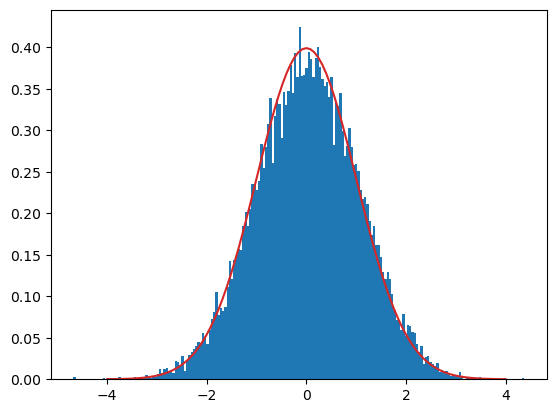

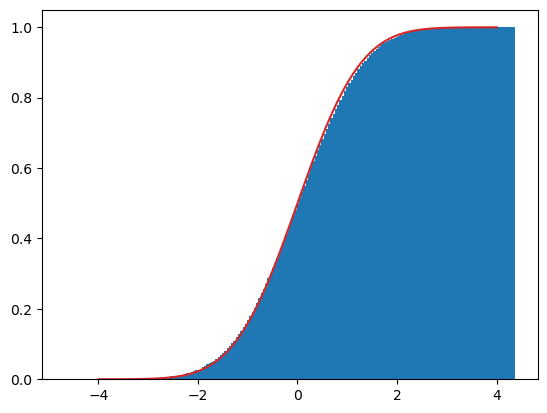

In [24]:
from tqdm import tqdm
n=20000

src_rate = 30
bkg_rate = 50
nbins = 1600
dE = (10 - 1) / nbins
edges = np.linspace(1, 10, nbins + 1)
observation = np.random.poisson((src_rate + bkg_rate) * dE, size=(n,nbins)).astype(float)
background = np.random.poisson(bkg_rate * dE, size=(n,nbins)).astype(float)
dE = np.diff(edges)
res = np.empty((n,3))
for i in tqdm(range(n)):
    res[i] = fit(observation[i], background[i], dE, src_rate, rebin=5)

import matplotlib.pyplot as plt
from scipy.stats import norm
_=plt.hist((res[:,0]-(src_rate))/res[:,1],bins=200, density=True)
plt.plot(np.linspace(-4,4,101), norm.pdf(np.linspace(-4,4,101)),c='tab:red')
plt.figure()
_=plt.hist((res[:,0]-(src_rate))/res[:,1],bins=200, density=True,cumulative=1)
plt.plot(np.linspace(-4,4,101), norm.cdf(np.linspace(-4,4,101)),c='tab:red')
print(f'max grad: {np.abs(res[:,2]).max():.2e}')

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1610.81it/s]


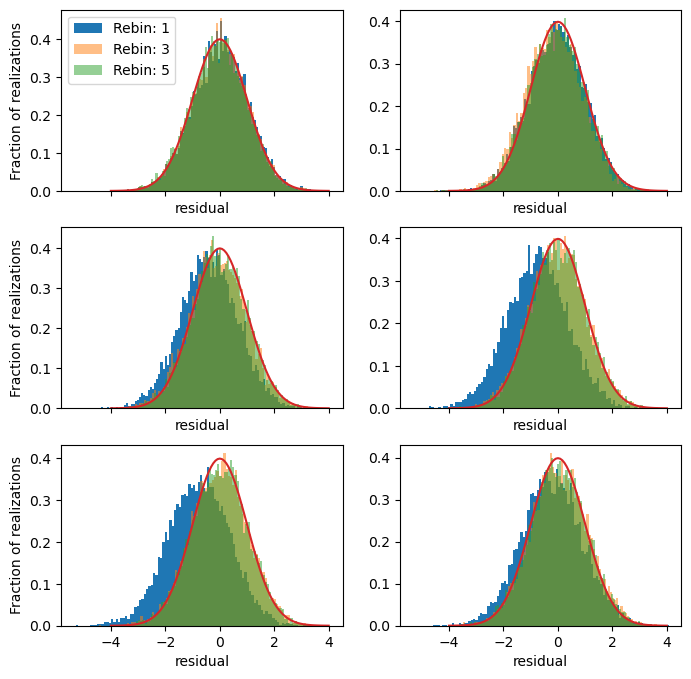

In [25]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, subs = plt.subplots(3,2, figsize=(8, 8), sharex=True)
number_of_bins = [50, 100, 200, 400, 500, 1600]
for i, (sub, n_bins) in enumerate(zip(subs.flatten(), 
                                      number_of_bins)):
    
    n=10000

    src_rate = 30
    bkg_rate = 50
    dE = (10 - 1) / n_bins
    edges = np.linspace(1, 10, n_bins + 1)
    observation = np.random.poisson((src_rate + bkg_rate) * dE, size=(n,n_bins)).astype(float)
    background = np.random.poisson(bkg_rate * dE, size=(n,n_bins)).astype(float)
    dE = np.diff(edges)
    res1 = np.empty((n,3))
    res3 = np.empty((n,3))
    res5 = np.empty((n,3))
    for ni in tqdm(range(n)):
        res1[ni] = fit(observation[ni], background[ni], dE, src_rate, rebin=1)
        res3[ni] = fit(observation[ni], background[ni], dE, src_rate, rebin=3)
        res5[ni] = fit(observation[ni], background[ni], dE, src_rate, rebin=5)
        
    _ = sub.hist((res1[:,0]-src_rate)/res1[:,1], 100, label='Rebin: 1', density=True)
    _ = sub.hist((res3[:,0]-src_rate)/res3[:,1], 100, label='Rebin: 3', alpha=0.5, density=True)
    _ = sub.hist((res5[:,0]-src_rate)/res5[:,1], 100, label='Rebin: 5', alpha=0.5, density=True)
    sub.plot(np.linspace(-4,4,101), norm.pdf(np.linspace(-4,4,101)),c='tab:red')
        
    sub.set_xlabel("residual")
    
    if (i+1) % 2 != 0:
        
        sub.set_ylabel("Fraction of realizations")


_ = subs[0][0].legend(loc=0)

In [224]:
def generate_data(n_bins, src_rate, bkg_rate):
    start = 1.0  # keV
    stop = 10.0  # keV

    dE = (stop - start) / n_bins

    edges = np.linspace(start, stop, n_bins + 1)

    energy_centers = (edges[1:] + edges[:-1]) / 2.0

    observation = np.random.poisson((src_rate + bkg_rate) * dE, n_bins).astype(float)

    background = np.random.poisson(bkg_rate * dE, n_bins).astype(float)

    return energy_centers, np.diff(edges), observation, background

generate_data(100, 30, 50)

(array([1.045, 1.135, 1.225, 1.315, 1.405, 1.495, 1.585, 1.675, 1.765,
        1.855, 1.945, 2.035, 2.125, 2.215, 2.305, 2.395, 2.485, 2.575,
        2.665, 2.755, 2.845, 2.935, 3.025, 3.115, 3.205, 3.295, 3.385,
        3.475, 3.565, 3.655, 3.745, 3.835, 3.925, 4.015, 4.105, 4.195,
        4.285, 4.375, 4.465, 4.555, 4.645, 4.735, 4.825, 4.915, 5.005,
        5.095, 5.185, 5.275, 5.365, 5.455, 5.545, 5.635, 5.725, 5.815,
        5.905, 5.995, 6.085, 6.175, 6.265, 6.355, 6.445, 6.535, 6.625,
        6.715, 6.805, 6.895, 6.985, 7.075, 7.165, 7.255, 7.345, 7.435,
        7.525, 7.615, 7.705, 7.795, 7.885, 7.975, 8.065, 8.155, 8.245,
        8.335, 8.425, 8.515, 8.605, 8.695, 8.785, 8.875, 8.965, 9.055,
        9.145, 9.235, 9.325, 9.415, 9.505, 9.595, 9.685, 9.775, 9.865,
        9.955]),
 array([0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
        0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
        0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09

In [270]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt


        
def cstat_wrapper(rate, obs, bkg, dE, rebin, full=False):
    y = np.repeat(rate * dE, obs.shape[0])
    res = wstat_rebin(obs, bkg, 1, 1, y, rebin=rebin)
    if full:
        return res
    else:
        return res[0], res[2].sum()

def fit(obs, bkg, dE, x0, rebin=0.0):
    def _objective_function(par):
        _fit_eval(par)
        print(__par, __obj, __jac, __hess)
        return __obj[0]

    def _jacobian(par):
        _fit_eval(par)
        return __jac[0]


    def _hessian(par):
        _fit_eval(par)
        return __hess[0]

    __par = [0.0]
    __obj = [None]
    __jac = [None]
    __hess = [None]
    
    def _fit_eval(par):
        if par == __par[0]:
            return None

        
        obj, mu_bkg, jac, hess = wstat(newS, newB, 1, 1, np.exp(par) * newdE)

        __par[0] = par
        __obj[0] = obj
        __jac[0] = (jac*np.exp(par)*newdE).sum()
        __hess[0] = [(hess*np.exp(par)*newdE + jac*np.exp(par)*newdE).sum()]
    
    newS, newB, newdE = spec_rebin(obs, bkg, dE, rebin=rebin)
    print(newS.shape, newB.shape, newdE.shape)
    x0 = np.log(x0)
    print('Nelder-Mead')
    results = minimize(_objective_function, x0=x0, method='Nelder-Mead')#, bounds=((1e-30,100),))
    print('Powell')
    results = minimize(_objective_function, x0=x0, method='Powell')
    print('bfgs')
    results = minimize(_objective_function, x0=x0, method='bfgs', jac=_jacobian, hess=_hessian)#, bounds=((1e-30,100),))
    print('trust-exact')
    results = minimize(_objective_function, x0=x0, method='trust-exact', jac=_jacobian, hess=_hessian)#, bounds=((1e-30,100),))

    if not results.success:
        print("Fit failed with reason %s" % results.message)
    print(results)

    return results.x

# def fit(obs, bkg, dE, x0, rebin=0.0):
#     def _objective_function(par):
#         _fit_eval(par)
#         print(__par, __obj, __jac, __hess)
#         return __obj[0]

#     def _jacobian(par):
#         _fit_eval(par)
#         return __jac[0]


#     def _hessian(par):
#         _fit_eval(par)
#         return __hess[0]

#     __par = [0.0]
#     __obj = [None]
#     __jac = [None]
#     __hess = [None]
    
#     def _fit_eval(par):
#         if np.allclose(par, __par):
#             return None

        
#         obj, mu_bkg, jac, hess = wstat(newS, newB, 1, 1, par * newdE)

#         __par[0] = par
#         __obj[0] = obj
#         __jac[0] = (jac*newdE).sum()
#         __hess[0] = [(hess*newdE).sum()]
    
#     newS, newB, newdE = spec_rebin(obs, bkg, dE, rebin=rebin)
#     print(newS.shape, newB.shape, newdE.shape)
#     x0 = 1e-4#np.log(x0)
#     print('Nelder-Mead')
#     results = minimize(_objective_function, x0=x0, method='Nelder-Mead')#, bounds=((1e-30,100),))
#     print('Powell')
#     results = minimize(_objective_function, x0=x0, method='Powell')
#     print('bfgs')
#     results = minimize(_objective_function, x0=x0, method='bfgs', jac=_jacobian, hess=_hessian)#, bounds=((1e-30,100),))
#     print('trust-exact')
#     results = minimize(_objective_function, x0=x0, method='trust-exact', jac=_jacobian, hess=_hessian)#, bounds=((1e-30,100),))

#     if not results.success:
#         print("Fit failed with reason %s" % results.message)
#     print(results)

#     return results.x
def fit_one_realization(seed,
                        n_bins,
                        true_src_rate,
                        true_bkg_rate,
                        plot=False,
                        rebin=0.0):

    np.random.seed(seed)

    energies, dE, obs, bkg = generate_data(n_bins,
                                           true_src_rate,
                                           true_bkg_rate)

    # print(np.average(obs - bkg) / dE)

    # We start the fit from very close to the true value so that if the fit
    # converges somewhere else it is something intrinsic to the
    # likelihood function, and not a minimization problem
    mle_est = fit(obs, bkg, dE, true_src_rate, rebin=rebin)

    if plot:

        # Get the values for the nuisance parameters
        bkg_nuisance = cstat_wrapper(mle_est, obs, bkg, dE,
                                     rebin=rebin,
                                     full=True)[1]

        _ = plt.errorbar(energies, obs, xerr=dE / 2.0,
                         yerr=np.sqrt(obs), fmt='.')

        _ = plt.errorbar(energies, bkg, xerr=dE / 2.0,
                         yerr=np.sqrt(bkg),
                         color='red', alpha=0.5, fmt='.')

        if rebin == 0:
            
            _ = plt.step(energies, bkg_nuisance,
                         color='red', where='mid',
                         label='Background model')

            _ = plt.step(energies,
                         mle_est * dE + bkg_nuisance,
                         color='blue', where='mid',
                         label='Total model')
            
            _ = plt.legend(loc=0)

        _ = plt.xlabel("Energy (keV)")
        _ = plt.ylabel("Counts per bin")
        

    return mle_est

(382,) (382,) (382,)
Nelder-Mead
[array([3.40119738])] [212.51944546207818] [-9.471647187582866] [[43.851560168105166]]
[array([3.57125725])] [211.75410094321072] [1.4452253985930241] [[63.75884860716097]]
[array([3.74131712])] [213.41102748969988] [19.439687228128708] [[91.41504728441393]]
[array([3.48622732])] [211.90569625091894] [-4.7437290639892975] [[52.968108606187826]]
[array([3.65628719])] [212.20130958799828] [9.39386980427566] [[76.48139350499264]]
[array([3.52874228])] [211.7641839353108] [-1.8496229711743073] [[58.138640638090706]]
[array([3.61377222])] [211.89329596718213] [5.179385023128664] [[69.86166891846733]]
[array([3.54999977])] [211.7416366634474] [-0.2546443476865221] [[60.890509311349696]]
[array([3.52874228])] [211.7641839353108] [-1.8496229711743073] [[58.138640638090706]]
[array([3.56062851])] [211.74335220533771] [0.5818765879404992] [[62.309862066553286]]
[array([3.53937103])] [211.74867240801464] [-1.0649449129469453] [[59.50027284862381]]
[array([3.555314

/Users/xuewc/miniconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method bfgs does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


array([34.92819863])

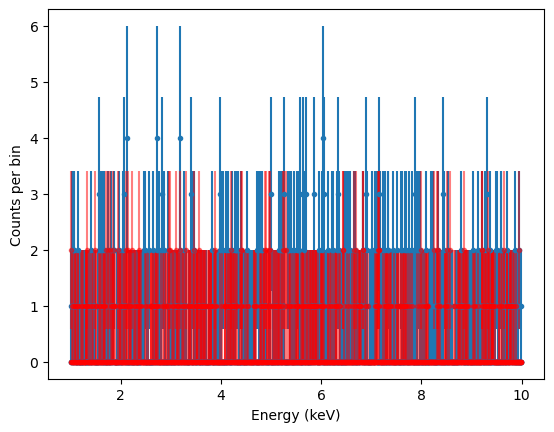

In [271]:
source_rate = 30.0
background_rate = 50.0
number_of_bins = 1600
# This is to guarantee repeatibility
random_seed = 0
mle_est = fit_one_realization(random_seed,
                    number_of_bins,
                    source_rate,
                    background_rate,
                    plot=True,
                    rebin=1)
np.exp(mle_est)

[]

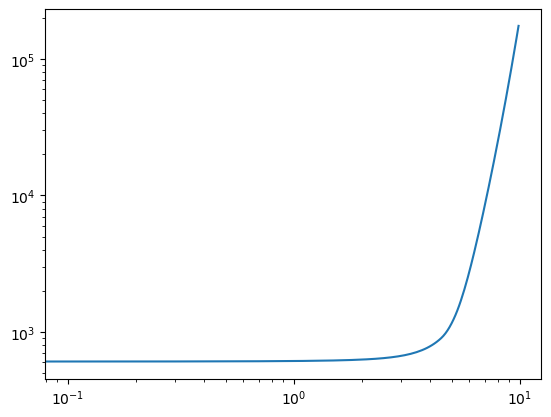

In [28]:
observation, background, dE=generate_data(1600, 30, 50)
p=np.arange(-10, 10, 0.1)
stat=[wstat_rebin(observation, background, 1, 1, np.full_like(observation, dE*np.exp(i)), rebin=0)[0] for i in p]
plt.plot(p,stat)
plt.loglog()